### **Projeto: Detecção de fraude em cartão de crédito**


---


Tradução e adaptação do código: Rodrigo da Costa Aglinskas

Projeto: Detecção de fraude em cartão de crédito

Desafio de projeto: Análise em Python com uso da biblioteca Pandas - DIO

Iniciado em 11/09/2021



### **Importando arquivos e bibliotecas**

In [2]:
# Importando as bibliotecas:

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
%matplotlib inline

from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string

import six
import sys
sys.modules['sklearn.externals.six'] = six

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN

import gensim
from gensim import corpora

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# Configuração Pandas:

pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)

In [45]:
# Leitura de arquivos:

#cc1_file = 'creditcard_sampledata.csv'

# arquivo original df com 147 MB
#df = pd.read_csv('creditcard_fraud2.csv', error_bad_lines=False)
df3 = pd.read_csv('amostraFraude.csv', error_bad_lines=False)

banksim_file = 'banksim.csv'
banksim_adj_file = 'banksim_adj.csv'
# arquivos pickle:
db_full_file = 'db_full.pickle'
labels_file = 'labels.pickle'
labels_full_file = 'labels_full.pickle'
x_scaled_file = 'x_scaled.pickle'
x_scaled_full_file = 'x_scaled_full.pickle'

enron_emails_clean_file = 'enron_emails_clean.csv'
# arquivos pickle:
cleantext_file = 'cleantext.pickle'
corpus_file = 'corpus.pickle'
dict_file = 'dict.pickle'
ldamodel_file = 'ldamodel.pickle'


b'Skipping line 47719: expected 31 fields, saw 42\n'


### **Tratando os dados**

In [16]:
# Criando uma amostra de 10% do df original
df2 = df.sample(frac=0.10)

In [44]:
# Baixando a amostra
df2.to_csv('amostraFraude.csv', encoding='utf-8', index=False)

In [46]:
# Verificando a estrutura do dataframe
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17277 entries, 0 to 17276
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  17277 non-null  int64  
 1   V1          17277 non-null  float64
 2   V2          17277 non-null  float64
 3   V3          17277 non-null  float64
 4   V4          17277 non-null  float64
 5   V5          17277 non-null  float64
 6   V6          17277 non-null  float64
 7   V7          17277 non-null  float64
 8   V8          17277 non-null  float64
 9   V9          17277 non-null  float64
 10  V10         17277 non-null  float64
 11  V11         17277 non-null  float64
 12  V12         17277 non-null  float64
 13  V13         17277 non-null  float64
 14  V14         17277 non-null  float64
 15  V15         17277 non-null  float64
 16  V16         17277 non-null  float64
 17  V17         17277 non-null  float64
 18  V18         17277 non-null  float64
 19  V19         17277 non-nul

In [47]:
df3.dtypes

Unnamed: 0      int64
V1            float64
V2            float64
V3            float64
V4            float64
V5            float64
V6            float64
V7            float64
V8            float64
V9            float64
V10           float64
V11           float64
V12           float64
V13           float64
V14           float64
V15           float64
V16           float64
V17           float64
V18           float64
V19           float64
V20           float64
V21           float64
V22           float64
V23           float64
V24           float64
V25           float64
V26           float64
V27           float64
V28           float64
Amount        float64
Class          object
dtype: object

In [48]:
#df["V4"] = pd.to_numeric(df["V4"], downcast="float")
# Convertendo coluna Class de object para int

df3['Class'] = pd.to_numeric(df3['Class'])

ValueError: ignored

In [50]:
# Localizando os valores com problema:

df3.loc[df3['Class']=="1'"]

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
201,28143,-27.143678,15.365804,-28.407424,6.370895,-20.087878,-4.666313,-18.709479,17.903574,-3.722279,-8.120962,4.419943,-6.210941,1.063837,-5.843528,-0.108836,-5.606597,-11.756256,-4.714947,0.783578,1.703888,1.796826,-1.960974,-0.902247,0.144011,2.024388,-0.204214,1.332153,0.385891,99.99,1'
323,152058,-3.576362,3.299436,-7.460433,7.783634,-0.398549,-1.968441,-3.110476,-0.328404,-1.574363,-2.497561,4.604170,-9.001915,-1.276324,-13.969471,1.256945,-4.491629,-5.969987,-1.274666,1.147784,-0.181455,0.540731,0.719526,0.379249,-0.616962,-0.442811,0.359841,-2.651825,0.422184,1.00,1'
861,110087,1.934946,0.650678,-0.286957,3.987828,0.316052,-0.099449,-0.021483,-0.172327,0.508730,1.072955,-0.427567,-2.777649,1.637140,1.571080,-1.445367,0.908650,-0.122016,-0.104110,-1.684022,-0.344452,-0.173602,-0.190974,0.219976,-0.216597,-0.136692,-0.129954,-0.050077,-0.051082,1.00,1'
1250,102676,-5.552122,5.678134,-9.775528,8.416295,-4.409844,-1.506235,-6.899839,3.750443,-3.879793,-6.864164,7.051065,-10.137529,2.815440,-9.909168,-0.262230,-5.022557,-8.522975,-2.012939,1.525732,-0.064780,1.128472,0.228484,0.286258,-0.536294,-0.104925,0.420919,-0.297557,-0.946184,119.74,1'
1627,143434,-2.729482,3.312495,-4.242710,5.036985,-0.376561,-1.532462,-3.449159,1.856839,-3.623334,-5.653638,3.942316,-5.883724,-1.347814,-9.266120,-2.459556,-2.205644,-5.709087,-1.113937,-1.556530,0.164288,0.727415,-0.301432,-0.502433,-0.462309,0.510683,0.046665,0.514646,0.140999,1.00,1'
1963,102480,-1.929597,4.066413,-4.865184,5.898602,-0.552493,-1.555962,-3.833623,0.679512,-3.463765,-6.683689,7.021278,-11.102493,1.711755,-10.447633,-2.799076,-6.261741,-11.647158,-3.451436,-0.507537,0.942489,1.137212,0.674245,-0.531765,-0.433409,0.378659,0.198107,0.869694,0.228048,0.00,1'
2271,148479,-1.541678,3.846800,-7.604114,3.121459,-1.254924,-2.084875,-2.385027,1.471140,-2.530507,-5.175660,1.927186,-6.011155,-1.195601,-6.745561,-0.058091,-4.325132,-5.558067,-1.580531,0.971906,0.114760,1.096405,1.064222,0.065370,0.257209,-0.693654,-0.335702,0.577052,0.398348,122.68,1'
2353,133184,-1.212682,-2.484824,-6.397186,3.670562,-0.863375,-1.855855,1.017732,-0.544704,-1.703378,-3.739659,1.738124,-2.844449,0.765864,-4.799737,-0.011335,-2.693168,-3.166955,-1.067800,-0.559132,2.908374,1.396872,0.092073,-1.492882,-0.204227,0.532511,-0.293871,0.212663,0.431095,1335.00,1'
2562,153653,-5.192496,3.164721,-5.047679,2.246597,-4.011781,-0.638908,-2.873463,1.576318,-2.861986,-2.120458,1.863596,-3.620252,-1.480714,-1.583343,-1.230469,-1.202298,-6.167637,-2.651539,0.013588,-1.850470,1.167244,-1.006617,0.774562,0.063397,-0.390658,1.884741,-1.742558,-0.082216,247.86,1'
2659,41397,-14.970346,8.401421,-16.867238,8.252334,-13.565130,-2.782438,-14.263735,9.643419,-7.701499,-14.226698,5.610999,-11.793979,1.598387,-11.606970,-0.044180,-9.286955,-19.899726,-7.518051,1.243517,-1.614660,2.714045,-0.101355,-0.439666,0.519514,0.789328,0.064357,-1.621386,-1.104819,273.01,1'


In [51]:
# erro: valores estão como 1', substituindo por 1:

df3['Class']= df3['Class'].replace(["1'"],["1"])

In [52]:
# Tentando novamente converter coluna Class de object para int

df3['Class'] = pd.to_numeric(df3['Class'])

# Agora funcionou.

In [53]:
# Checando os tipos:

df3.dtypes

Unnamed: 0      int64
V1            float64
V2            float64
V3            float64
V4            float64
V5            float64
V6            float64
V7            float64
V8            float64
V9            float64
V10           float64
V11           float64
V12           float64
V13           float64
V14           float64
V15           float64
V16           float64
V17           float64
V18           float64
V19           float64
V20           float64
V21           float64
V22           float64
V23           float64
V24           float64
V25           float64
V26           float64
V27           float64
V28           float64
Amount        float64
Class         float64
dtype: object

In [54]:
df3.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,165825,2.009861,-0.869738,-1.754567,-0.423925,-0.186998,-0.756014,0.067375,-0.372006,-0.675936,0.841376,-1.173789,0.041871,0.501777,0.204775,-0.207727,-1.730563,-0.038104,0.588551,-0.531336,-0.358859,-0.451073,-0.949828,0.189053,0.581766,-0.152222,0.484464,-0.095600,-0.042231,113.96,0.0
1,146492,-1.804326,1.504552,-0.233085,-1.229363,1.502214,-0.347973,2.406507,-1.635108,2.463650,4.251623,1.835383,0.484691,0.557624,-1.710859,0.174277,-1.041797,-1.570204,0.131513,0.051017,1.408423,-0.299683,1.489198,-0.243334,0.744379,-0.480553,-0.435355,0.128771,-0.350759,44.99,0.0
2,96364,-0.826149,0.687367,0.833079,-0.538347,0.039801,0.080615,-0.206940,0.513953,1.749362,-1.191956,-1.421861,-2.980938,1.457096,1.406513,-0.710242,0.673623,-0.008299,0.930974,-0.226166,-0.023124,0.102609,0.576929,-0.246134,-1.012641,-0.208986,0.625561,0.218520,0.119810,29.99,0.0
3,120477,2.098926,0.318974,-2.724961,0.394636,1.246655,-0.707107,0.649341,-0.299002,-0.180722,-0.151160,0.755647,0.610829,0.035880,-0.528841,-0.871319,0.101675,0.360497,0.479553,0.384748,-0.138251,0.054431,0.311851,-0.107287,0.167923,0.483469,0.510968,-0.093167,-0.062508,5.95,0.0
4,86469,2.183102,-1.566933,-0.515539,-1.662056,-1.455993,-0.221062,-1.400477,-0.007258,-1.245094,1.663325,0.382201,0.017236,0.821759,-0.482807,-0.631955,0.076368,-0.059152,0.446303,0.312842,-0.314990,-0.358131,-0.652055,0.359658,-0.553220,-0.580116,-0.478611,0.028788,-0.042655,50.70,0.0


In [55]:
df3.tail()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
17272,123115,2.139878,-1.583200,-0.288288,-1.535987,-1.733348,-0.468167,-1.436146,0.007986,-1.219286,1.668009,0.860138,-0.007746,0.287187,-0.358186,-0.578501,-0.125739,0.225537,0.226986,0.033572,-0.372819,-0.322077,-0.559133,0.443312,-0.054590,-0.683546,-0.506486,0.030403,-0.038949,47.89,0.0
17273,148070,-0.562531,-0.506484,-1.039462,0.218595,0.677860,-0.750326,0.246022,0.247663,0.203338,-0.675191,-1.403481,0.871656,1.046859,0.298470,-0.392649,-0.773854,0.121332,-0.245944,1.220536,0.377078,0.276119,0.459274,0.642919,0.621261,-1.982013,-0.311336,0.247870,0.167263,118.30,0.0
17274,122983,0.214368,0.980133,-0.406356,-0.156124,-0.047271,-0.668597,-0.220436,-2.639315,-0.046422,-0.012585,1.466766,1.394169,0.095682,0.835964,-0.183429,-0.339161,-0.328910,0.231018,-0.211038,-0.643820,2.708192,0.546147,0.160335,0.510178,0.133963,-0.156077,0.360756,0.348319,0.89,0.0
17275,129005,2.060179,0.153654,-1.999886,1.033370,0.982823,-0.237673,0.515198,-0.204025,0.019098,0.430197,-0.200692,0.651070,-0.210077,0.676870,-1.139438,-0.241234,-0.748883,0.175277,0.454110,-0.262248,0.032905,0.294458,-0.139976,-1.092219,0.564168,-0.442902,-0.019900,-0.082902,7.55,0.0
17276,136360,-0.479591,1.017677,0.996117,1.237626,-0.251486,0.072080,0.264613,0.491500,0.015655,-0.717522,-1.590319,0.463396,-0.113175,0.039069,-1.013210,-0.807608,0.472216,-0.605754,1.166386,-0.145154,-0.355473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
# o df tem valores com NaN
# Substituindo por zero:

df3 = df3.replace(np.nan, 0)

### **Verificando a relação fraude x não fraude**

In [66]:
# Conta ocorrências de fraude and não fraude e imprime:

occ = df3['Class'].value_counts()
occ

0.0    17242
1.0       35
Name: Class, dtype: int64

In [67]:
# Imprime a Razão de casos de fraude em relação ao total:

ratio_cases = occ/len(df3.index)
print(f'Razão de ocorrências de fraude: {ratio_cases[1]}\nRazão de ocorrências não fraudulentas: {ratio_cases[0]}')

Razão de ocorrências de fraude: 0.0020258146668981885
Razão de ocorrências não fraudulentas: 0.9979741853331018


### **Visualização de dados**

In [68]:
# função preparando o df

def prep_data(df3: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28)
    y: lable column
    """
    X = df3.iloc[:, 1:28].values
    y = df3.Class.values
    return X, y

In [69]:
# Função cria um scatter plot dos dados e etiquetas
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

In [70]:
# Cria X e y da função prep_data
X, y = prep_data(df3)

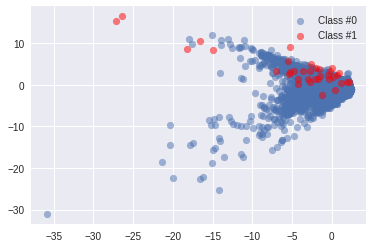

In [71]:
# Gerando gráfico dos dados pela função plot data em X and y
plot_data(X, y)

### **Reamostragem de dados: aumenta a detecção bem-sucedida**

In [72]:
# Undersampling  x Oversampling

# Implementando métodos de reamostragem usando o módulo Python imblean 

from imblearn.over_sampling import RandomOverSampler



# Define o método de reamostragem em treino e teste
method = SMOTE(kind='borderline1')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

# Aplica a reamostragem apenas aos dados de treinamento 
X_resampled, y_resampled = method.fit_sample(X_train, y_train)

# Ajusta o modelo e obtém previsões
model = LogisticRegression()
model.fit(X_resampled, y_resampled)

# Obtem métricas de desempenho do modelo
predicted = model.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      3449
         1.0       0.08      0.57      0.14         7

    accuracy                           0.99      3456
   macro avg       0.54      0.78      0.57      3456
weighted avg       1.00      0.99      0.99      3456



In [73]:
# Métodos de reamostragem para dados desequilibrados
# Aplicando o Synthetic Minority Oversampling Technique (SMOTE)

# Executando a função prep_data
X, y = prep_data(df3)

In [74]:
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (17277, 27)
y shape: (17277,)


In [75]:
# Definindo o método de reamostragem
method = SMOTE()

In [76]:
# Cria um conjunto de recursos reamostrado 
X_resampled, y_resampled = method.fit_sample(X, y)

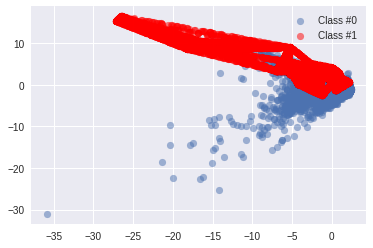

In [83]:
# Plotando os dados reamostrados 
plot_data(X_resampled, y_resampled)

In [80]:
df3 = df3.loc[:, df3.notnull().any(axis = 0)]

In [84]:
#Compare SMOTE to original data

pd.value_counts(pd.Series(y))

0.0    17242
1.0       35
dtype: int64

In [85]:
pd.value_counts(pd.Series(y_resampled))



1.0    17242
0.0    17242
dtype: int64

In [86]:
# Função compara o df original com o de reamostragem:

def compare_plot(X: np.ndarray, y: np.ndarray, X_resampled: np.ndarray, y_resampled: np.ndarray, method: str):
    plt.subplot(1, 2, 1)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title('Original Set')
    plt.subplot(1, 2, 2)
    plt.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title(method)
    plt.legend()
    plt.show()

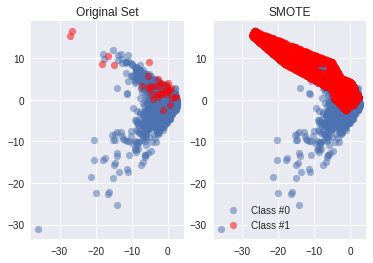

In [87]:
compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')

### **Algoritmos de detecção de fraude**

In [88]:
# Sistemas baseados em Machine Learning

# 1: divide os recursos e rótulos em dados de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = LinearRegression().fit(X_train, y_train)

In [90]:
# 2: Define o modelo a usar
model = LinearRegression()

In [91]:
# 3: Ajusta o modelo aos dados de treino
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [92]:
# 4: Obtém o modelo preditivo para os dados de teste
y_predicted = model.predict(X_test)

In [93]:
# 5: Compara y_test as previsões e obtém métricas de performance (r^2 score)
r2_score(y_test, y_predicted)

0.3845293838008095

In [95]:
# Método tradicional de detecção de fraude:

df3.drop(['Unnamed: 0'], axis=1, inplace=True)

In [96]:
df3.groupby('Class').mean()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,0.009439,-0.001805,0.021010,0.011530,-0.004148,-0.007924,0.008020,0.008482,0.000052,0.020030,-0.001909,0.000044,-0.001813,0.007898,0.004082,0.016634,0.008029,0.008133,-0.011989,0.001855,-0.000022,0.004003,0.009246,0.004724,-0.003422,-0.004923,0.004336,0.000193,87.696876
1.0,-4.667419,3.777429,-7.161397,4.674206,-3.060247,-1.588470,-4.989313,1.190166,-2.643009,-5.378959,3.499545,-6.022551,-0.185685,-7.025335,-0.347639,-3.506873,-5.948517,-1.936091,0.238785,0.311450,0.582645,-0.077355,-0.342653,-0.073031,0.165081,0.150824,-0.109410,0.102796,140.206286


In [100]:
df3['flag_as_fraud'] = np.where(np.logical_and(df3.V1 < -3, df3.V3 < -5), 1, 0)

In [101]:
pd.crosstab(df3.Class, df3.flag_as_fraud, rownames=['Actual Fraud'], colnames=['Flagged Fraud'])

Flagged Fraud,0,1
Actual Fraud,,
0.0,17158,84
1.0,24,11


**Using ML classification to catch fraud**

In [102]:
# Criando conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [103]:
# Ajustando o modelo de regressão logístrica aos dados
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [104]:
# Obtendo modelos preditivos
predicted = model.predict(X_test)

In [105]:
# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5176
         1.0       0.80      0.50      0.62         8

    accuracy                           1.00      5184
   macro avg       0.90      0.75      0.81      5184
weighted avg       1.00      1.00      1.00      5184

Confusion matrix:
 [[5175    1]
 [   4    4]]


**Regressão Logístrica com SMOTE**

In [108]:
# Definindo qual método de reamostragem e o modelo de ML do pipeline
# resampling = SMOTE(kind='borderline2')  # has been changed to BorderlineSMOTE
resampling = BorderlineSMOTE()
model = LogisticRegression(solver='liblinear')

In [107]:
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

**Pipelining**

In [110]:
# Separando os dados em X e y, em conjunto de treino e teste e ajustando o pipeline nos dados de treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [111]:
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)

In [112]:
# Obtendo os resultados do relatório de classificação e matriz de confusão 
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classifcation report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      5176
         1.0       0.09      0.50      0.15         8

    accuracy                           0.99      5184
   macro avg       0.54      0.75      0.57      5184
weighted avg       1.00      0.99      0.99      5184

Confusion matrix:
 [[5134   42]
 [   4    4]]


### **Detecção de fraude usando dados rotulados**

### **Referências:**

https://www.teses.usp.br/teses/disponiveis/45/45134/tde-01022016-204144/publico/Paulo_Oliveira_Mestrado_PPGCC.pdf

https://towardsdatascience.com/understand-and-build-fp-growth-algorithm-in-python-d8b989bab342

https://trenton3983.github.io/files/projects/2019-07-19_fraud_detection_python/2019-07-19_fraud_detection_python.html

people described by a set of attributes as good or bad credit risks.
https://www.openml.org/d/31

creditcard fraud  in September 2013 by european cardholders
https://www.openml.org/d/42175
https://www.openml.org/d/1597